In [13]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# zero weight init
def zero_weights(model):
    for param in model.parameters():
        param.data.zero_()
        
# configure model and other stuff
lookahead, lookback = 4, 12
dtype = torch.float32
device = 'cuda'
num_clients = 12
        
xformer_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'd_model' : 256,
    'e_layers' : 3,
    'd_layers' : 3,
    'dtype' : dtype
}
darnn_model_kwargs = {
    'x_size': 6,
    'y_size': 1,
    'u_size': 2,
    's_size': 7,
    'lookback': lookback,
    'lookahead': lookahead,
    'dtype' : dtype
}

On step 109, loss is 46434.90625.:   1%|█▊                                                                                                                                                                                | 109/10508 [00:15<1:36:10,  1.80it/s]

On step 100, MAPE error is 96.94809209216724 percent.


On step 209, loss is 68924.90625.:   2%|███▌                                                                                                                                                                              | 209/10508 [00:30<1:37:13,  1.77it/s]

On step 200, MAPE error is 581.4903302626176 percent.


On step 309, loss is 338831.1875.:   3%|█████▏                                                                                                                                                                            | 309/10508 [00:45<1:34:21,  1.80it/s]

On step 300, MAPE error is 95.52177570082925 percent.


On step 409, loss is 56991.51171875.:   4%|██████▊                                                                                                                                                                        | 409/10508 [01:00<1:35:12,  1.77it/s]

On step 400, MAPE error is 715.0922298431396 percent.


On step 509, loss is 135971.765625.:   5%|████████▌                                                                                                                                                                       | 509/10508 [01:14<1:32:09,  1.81it/s]

On step 500, MAPE error is 95.66662365739995 percent.


On step 609, loss is 305537.0.:   6%|██████████▍                                                                                                                                                                          | 609/10508 [01:29<1:32:07,  1.79it/s]

On step 600, MAPE error is 898.3387686989524 percent.


On step 709, loss is 45726.796875.:   7%|███████████▉                                                                                                                                                                     | 709/10508 [01:44<1:30:20,  1.81it/s]

On step 700, MAPE error is 96.60886417735706 percent.


On step 809, loss is 252342.46875.:   8%|█████████████▋                                                                                                                                                                   | 809/10508 [01:59<1:30:12,  1.79it/s]

On step 800, MAPE error is 1026.0041236877441 percent.


On step 909, loss is 94011.5.:   9%|███████████████▋                                                                                                                                                                      | 905/10508 [02:14<1:47:22,  1.49it/s]

On step 900, MAPE error is 97.33000722798434 percent.


On step 1000, loss is 64726.6328125.:  10%|████████████████▊                                                                                                                                                                | 999/10508 [02:29<23:43,  6.68it/s]

On step 1000, MAPE error is 3036.6256193681197 percent.


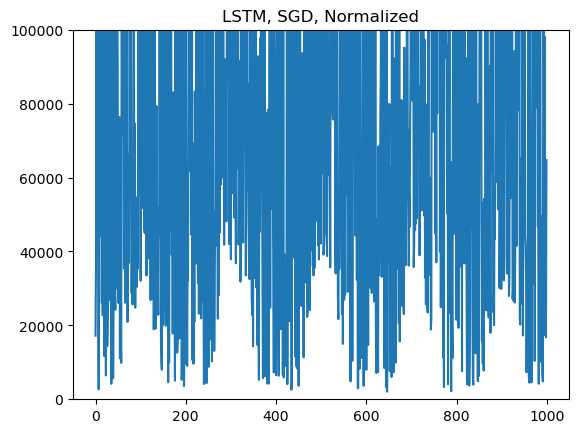

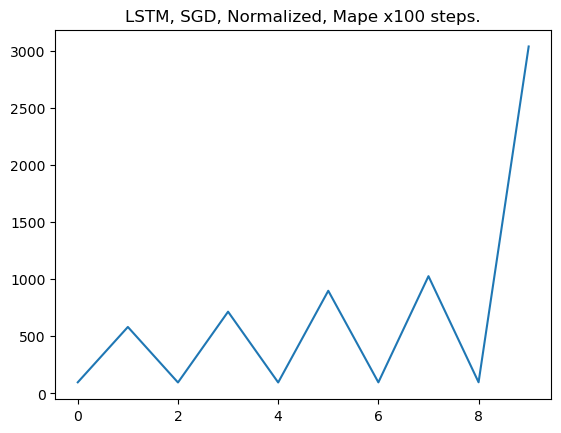

In [14]:
# set up paths and custom imports
module_path = '/home/sbose/time-series-forecasting-federation'
sys.path.insert(0,module_path)

from files_for_appfl.comstock_dataloader import get_comstock
from files_for_appfl.loss import MSELoss
from files_for_appfl.metric import mape
from models.TRANSFORMER.Transformer import Transformer
from models.CROSSFORMER.Crossformer import Crossformer
from models.LSTM.LSTMAR import LSTMAR

# initialize objects
model = nn.DataParallel(LSTMAR(**darnn_model_kwargs))
model = model.to(device)
loss_fn = MSELoss()

# get and combine datasets
train_set, test_set = [], []
for bidx in range(num_clients):
    train, test = get_comstock(
        bldg_idx = bidx,
        lookback = lookback,
        lookahead = lookahead,
        dtype = dtype,
        normalize = True
    )
    train_set.append(train)
    test_set.append(test)
train_set, test_set = ConcatDataset(train_set), ConcatDataset(test_set)

# create dataloaders
seed, BS = 42, 32
torch.manual_seed(seed)
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8096, shuffle=True)

# start training

# hyperparams
lr = 5e-4
steps = 1000
test_every = 100

optim = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = lr_scheduler.CosineAnnealingLR(optim, T_max=10, eta_min=1e-5)
elapsed = 0

loss_record, mape_record = [], []

zero_weights(model)
for inp, lab in (t:=tqdm(train_loader)):
    
    inp, lab = inp.to(device), lab.to(device)
    pred = model(inp)
    loss = loss_fn(lab,pred)
    optim.zero_grad
    loss.backward()
    optim.step()
    # scheduler.step()    
    loss_record.append(loss.item())
    elapsed += 1
    
    t.set_description(f"On step {elapsed}, loss is {loss.item()}.")
    
    if elapsed % test_every == 0:
        mapes = []
        for inp,lab in test_loader:
            inp = inp.to(device)
            with torch.no_grad():
                pred = model(inp)
            mapes.append(mape(lab.to('cpu').numpy(),pred.to('cpu').numpy()))
        metric = np.mean(np.array(mapes))
        mape_record.append(metric)
        print(f"On step {elapsed}, MAPE error is {metric} percent.")
        
    if elapsed == steps:
        break
    
plt.plot(np.array(loss_record))
plt.title('Losses')
plt.title('LSTM, SGD, Normalized')
plt.ylim(0,1e+5)
plt.show()
plt.plot(np.array(mape_record))
plt.title(f'LSTM, SGD, Normalized, Mape x{test_every} steps.')
plt.show()


On step 109, loss is 151.21771240234375.:   1%|█▊                                                                                                                                                                         | 109/10508 [00:15<1:41:41,  1.70it/s]

On step 100, MAPE error is 69.60976015437733 percent.


On step 209, loss is 137.26956176757812.:   2%|███▎                                                                                                                                                                       | 205/10508 [00:31<2:01:25,  1.41it/s]

On step 200, MAPE error is 991.2843964316628 percent.


On step 309, loss is 486.42816162109375.:   3%|████▉                                                                                                                                                                      | 305/10508 [00:47<1:39:59,  1.70it/s]

On step 300, MAPE error is 70.18902952020818 percent.


On step 409, loss is 126.8971939086914.:   4%|██████▋                                                                                                                                                                     | 405/10508 [01:03<1:40:52,  1.67it/s]

On step 400, MAPE error is 1572.7336103265936 percent.


On step 509, loss is 197.75021362304688.:   5%|████████▏                                                                                                                                                                  | 505/10508 [01:18<1:37:41,  1.71it/s]

On step 500, MAPE error is 70.06143439899792 percent.


On step 609, loss is 490.14715576171875.:   6%|█████████▊                                                                                                                                                                 | 605/10508 [01:34<1:38:56,  1.67it/s]

On step 600, MAPE error is 1450.594711303711 percent.


On step 709, loss is 127.21112823486328.:   7%|███████████▍                                                                                                                                                               | 705/10508 [01:50<1:35:40,  1.71it/s]

On step 700, MAPE error is 69.68345587903804 percent.


On step 809, loss is 375.800537109375.:   8%|█████████████▎                                                                                                                                                               | 805/10508 [02:06<1:35:55,  1.69it/s]

On step 800, MAPE error is 6519.179812344638 percent.


On step 909, loss is 187.42105102539062.:   9%|██████████████▋                                                                                                                                                            | 905/10508 [02:21<1:33:34,  1.71it/s]

On step 900, MAPE error is 69.7267082604495 percent.


On step 1000, loss is 162.24169921875.:  10%|████████████████▋                                                                                                                                                              | 999/10508 [02:37<24:56,  6.35it/s]

On step 1000, MAPE error is 1316.4372184059837 percent.


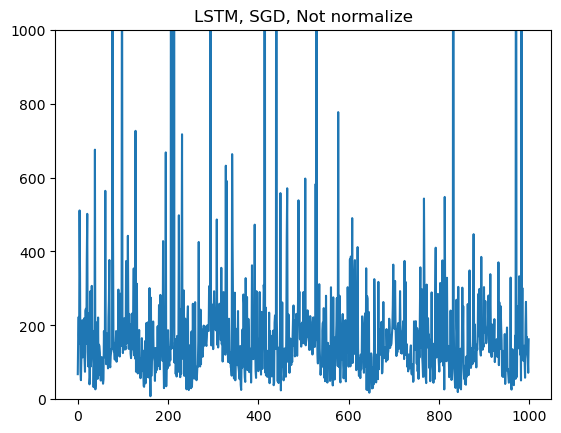

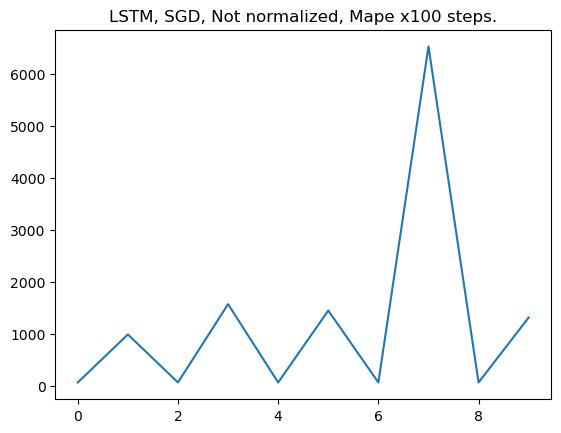

In [17]:
# set up paths and custom imports
module_path = '/home/sbose/time-series-forecasting-federation'
sys.path.insert(0,module_path)

from files_for_appfl.comstock_dataloader import get_comstock
from files_for_appfl.loss import MSELoss
from files_for_appfl.metric import mape
from models.TRANSFORMER.Transformer import Transformer
from models.CROSSFORMER.Crossformer import Crossformer
from models.LSTM.LSTMAR import LSTMAR

# initialize objects
model = nn.DataParallel(LSTMAR(**darnn_model_kwargs))
model = model.to(device)
loss_fn = MSELoss()

# get and combine datasets
train_set, test_set = [], []
for bidx in range(num_clients):
    train, test = get_comstock(
        bldg_idx = bidx,
        lookback = lookback,
        lookahead = lookahead,
        dtype = dtype,
        normalize = False
    )
    train_set.append(train)
    test_set.append(test)
train_set, test_set = ConcatDataset(train_set), ConcatDataset(test_set)

# create dataloaders
seed, BS = 42, 32
torch.manual_seed(seed)
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8096, shuffle=True)

# start training

# hyperparams
lr = 5e-4
steps = 1000
test_every = 100

optim = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = lr_scheduler.CosineAnnealingLR(optim, T_max=10, eta_min=1e-5)
elapsed = 0

loss_record, mape_record = [], []

zero_weights(model)
for inp, lab in (t:=tqdm(train_loader)):
    
    inp, lab = inp.to(device), lab.to(device)
    pred = model(inp)
    loss = loss_fn(lab,pred)
    optim.zero_grad
    loss.backward()
    optim.step()
    # scheduler.step()    
    loss_record.append(loss.item())
    elapsed += 1
    
    t.set_description(f"On step {elapsed}, loss is {loss.item()}.")
    
    if elapsed % test_every == 0:
        mapes = []
        for inp,lab in test_loader:
            inp = inp.to(device)
            with torch.no_grad():
                pred = model(inp)
            mapes.append(mape(lab.to('cpu').numpy(),pred.to('cpu').numpy()))
        metric = np.mean(np.array(mapes))
        mape_record.append(metric)
        print(f"On step {elapsed}, MAPE error is {metric} percent.")
        
    if elapsed == steps:
        break
    
plt.plot(np.array(loss_record))
plt.title('Losses')
plt.title('LSTM, SGD, Not normalize')
plt.ylim(0,1e+3)
plt.show()
plt.plot(np.array(mape_record))
plt.title(f'LSTM, SGD, Not normalized, Mape x{test_every} steps.')
plt.show()


On step 108, loss is 426.31390380859375.:   1%|█▋                                                                                                                                                                         | 105/10508 [00:15<2:01:17,  1.43it/s]

On step 100, MAPE error is 12116.211561723188 percent.


On step 209, loss is 123.96168518066406.:   2%|███▎                                                                                                                                                                       | 205/10508 [00:31<1:42:35,  1.67it/s]

On step 200, MAPE error is 5489.242276278409 percent.


On step 308, loss is 59.337562561035156.:   3%|████▉                                                                                                                                                                      | 305/10508 [00:47<1:39:31,  1.71it/s]

On step 300, MAPE error is 3519.5966893976383 percent.


On step 408, loss is 217.27279663085938.:   4%|██████▌                                                                                                                                                                    | 405/10508 [01:03<1:40:35,  1.67it/s]

On step 400, MAPE error is 2569.4162021983752 percent.


On step 509, loss is 258.77520751953125.:   5%|████████▏                                                                                                                                                                  | 505/10508 [01:18<1:37:36,  1.71it/s]

On step 500, MAPE error is 2013.0074240944602 percent.


On step 609, loss is 461.169921875.:   6%|██████████▏                                                                                                                                                                     | 605/10508 [01:34<1:38:25,  1.68it/s]

On step 600, MAPE error is 1657.225764881481 percent.


On step 709, loss is 122.11076354980469.:   7%|███████████▍                                                                                                                                                               | 705/10508 [01:50<1:35:36,  1.71it/s]

On step 700, MAPE error is 1400.962950966575 percent.


On step 809, loss is 367.4156494140625.:   8%|█████████████▏                                                                                                                                                              | 805/10508 [02:06<1:36:43,  1.67it/s]

On step 800, MAPE error is 1218.1320277127352 percent.


On step 909, loss is 223.94332885742188.:   9%|██████████████▋                                                                                                                                                            | 905/10508 [02:21<1:33:38,  1.71it/s]

On step 900, MAPE error is 1072.7691650390625 percent.


On step 1009, loss is 166.03421020507812.:  10%|████████████████▏                                                                                                                                                        | 1005/10508 [02:37<1:34:43,  1.67it/s]

On step 1000, MAPE error is 954.4665423306552 percent.


On step 1109, loss is 57.542198181152344.:  11%|█████████████████▊                                                                                                                                                       | 1105/10508 [02:53<1:32:05,  1.70it/s]

On step 1100, MAPE error is 861.7216890508479 percent.


On step 1209, loss is 143.62783813476562.:  11%|███████████████████▍                                                                                                                                                     | 1205/10508 [03:09<1:32:31,  1.68it/s]

On step 1200, MAPE error is 787.2162688862194 percent.


On step 1309, loss is 119.64930725097656.:  12%|████████████████████▉                                                                                                                                                    | 1305/10508 [03:24<1:30:00,  1.70it/s]

On step 1300, MAPE error is 721.1295908147639 percent.


On step 1409, loss is 166.78147888183594.:  13%|██████████████████████▌                                                                                                                                                  | 1405/10508 [03:40<1:30:48,  1.67it/s]

On step 1400, MAPE error is 666.9238437305797 percent.


On step 1509, loss is 43.537803649902344.:  14%|████████████████████████▏                                                                                                                                                | 1505/10508 [03:56<1:27:39,  1.71it/s]

On step 1500, MAPE error is 619.4508595900102 percent.


On step 1609, loss is 48.82096862792969.:  15%|█████████████████████████▉                                                                                                                                                | 1605/10508 [04:12<1:28:31,  1.68it/s]

On step 1600, MAPE error is 577.638747475364 percent.


On step 1709, loss is 297.0218505859375.:  16%|███████████████████████████▌                                                                                                                                              | 1705/10508 [04:27<1:25:54,  1.71it/s]

On step 1700, MAPE error is 541.9816103848544 percent.


On step 1809, loss is 163.47805786132812.:  17%|█████████████████████████████                                                                                                                                            | 1805/10508 [04:43<1:26:41,  1.67it/s]

On step 1800, MAPE error is 510.0421992215243 percent.


On step 1909, loss is 210.7700653076172.:  18%|██████████████████████████████▊                                                                                                                                           | 1905/10508 [04:59<1:24:02,  1.71it/s]

On step 1900, MAPE error is 483.6403239857067 percent.


On step 2000, loss is 148.3845977783203.:  19%|████████████████████████████████▋                                                                                                                                           | 1999/10508 [05:14<22:20,  6.35it/s]

On step 2000, MAPE error is 457.0956056768244 percent.


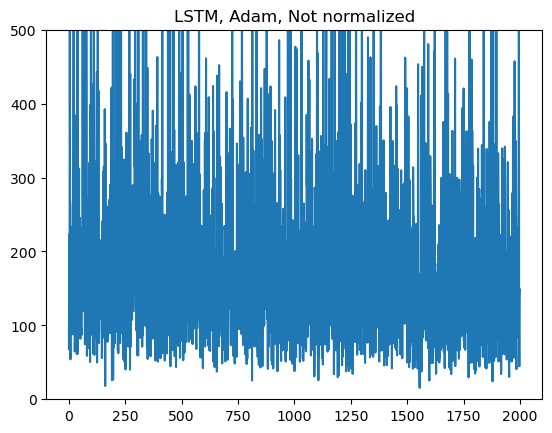

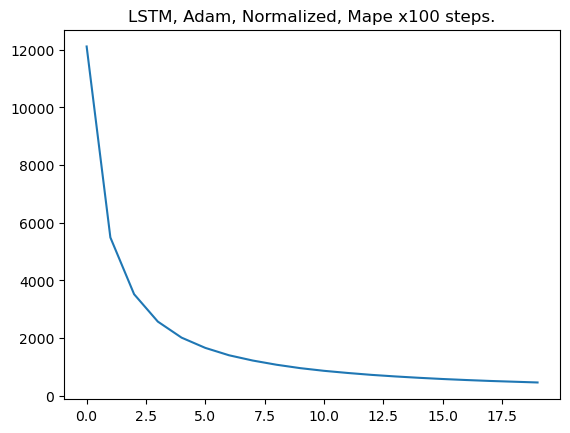

In [18]:

# set up paths and custom imports
module_path = '/home/sbose/time-series-forecasting-federation'
sys.path.insert(0,module_path)

from files_for_appfl.comstock_dataloader import get_comstock
from files_for_appfl.loss import MSELoss
from files_for_appfl.metric import mape
from models.TRANSFORMER.Transformer import Transformer
from models.CROSSFORMER.Crossformer import Crossformer
from models.LSTM.LSTMAR import LSTMAR

# initialize objects
model = nn.DataParallel(LSTMAR(**darnn_model_kwargs))
model = model.to(device)
loss_fn = MSELoss()

# get and combine datasets
train_set, test_set = [], []
for bidx in range(num_clients):
    train, test = get_comstock(
        bldg_idx = bidx,
        lookback = lookback,
        lookahead = lookahead,
        dtype = dtype,
        normalize = False
    )
    train_set.append(train)
    test_set.append(test)
train_set, test_set = ConcatDataset(train_set), ConcatDataset(test_set)

# create dataloaders
seed, BS = 42, 32
torch.manual_seed(seed)
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8096, shuffle=True)

# start training

# hyperparams
lr = 5e-4
steps = 2000
test_every = 100

optim = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.CosineAnnealingLR(optim, T_max=10, eta_min=1e-5)
elapsed = 0

loss_record, mape_record = [], []

zero_weights(model)
for inp, lab in (t:=tqdm(train_loader)):
    
    inp, lab = inp.to(device), lab.to(device)
    pred = model(inp)
    loss = loss_fn(lab,pred)
    optim.zero_grad
    loss.backward()
    optim.step()
    # scheduler.step()    
    loss_record.append(loss.item())
    elapsed += 1
    
    t.set_description(f"On step {elapsed}, loss is {loss.item()}.")
    
    if elapsed % test_every == 0:
        mapes = []
        for inp,lab in test_loader:
            inp = inp.to(device)
            with torch.no_grad():
                pred = model(inp)
            mapes.append(mape(lab.to('cpu').numpy(),pred.to('cpu').numpy()))
        metric = np.mean(np.array(mapes))
        mape_record.append(metric)
        print(f"On step {elapsed}, MAPE error is {metric} percent.")
        
    if elapsed == steps:
        break
    
plt.plot(np.array(loss_record))
plt.title('Losses')
plt.ylim(0,5e+2)
plt.title('LSTM, Adam, Not normalized')
plt.show()
plt.plot(np.array(mape_record))
plt.title(f'LSTM, Adam, Normalized, Mape x{test_every} steps.')
plt.show()

